<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 19: Optimizers
### Notebook 3: Demonstrate the effect of the learning rate

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hsv_to_rgb

import math
import numpy as np
import seaborn as sbn; sbn.set()

In [2]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [3]:
def make_ds(xs, ys):
    ds = []
    dx = xs[1]-xs[0]
    for i in range(len(xs)):
        if i==0:
            dnew = (ys[1]-ys[0])/dx
        elif i==len(xs)-1:
            dnew = (ys[-1]-ys[-2])/dx
        else:
            dnew = (ys[i+1]-ys[i-1])/(2*dx)
        ds.append(dnew)
    return ds

In [4]:
def get_xyd_at_val(v, xs, ys, ds):
    if v <= xs[0]:
        return (xs[0], ys[0], ds[0])
    if v >= xs[-1]:
        return(xs[-1], ys[-1], ds[-1])
    i = 1
    while (v > xs[i]) and (i < len(xs)-1):
        i += 1
    if i >= len(xs)-1:
        return(xs[-1], ys[-1], ds[-1])
    lerp = (v-xs[i-1])/(xs[1]-xs[0])
    x = xs[i] + lerp * (xs[i+1]-xs[i])
    y = ys[i] + lerp * (ys[i+1]-ys[i])
    d = ds[i] + lerp * (ds[i+1]-ds[i])
    return (x, y, d)

In [5]:
def make_bowl_data(numpoints=201):
    bowl_scale = 7
    xs = np.linspace(-1, 1, numpoints)
    ys = [10*(1-np.exp(-bowl_scale*x*x)) for x in xs]
    #ds = []
    #dx = xs[1]-xs[0]
    #for i in range(len(xs)):
        #if i==0:
            #dnew = (ys[1]-ys[0])/dx
        #elif i==len(xs)-1:
            #dnew = (ys[-1]-ys[-2])/dx
        #else:
            #dnew = (ys[i+1]-ys[i-1])/dx
        #ds.append(dnew/2.0)
    ds = make_ds(xs, ys)
    return (xs, ys, ds)

In [6]:
def make_up_plateau_down(numpoints=200):
    xs = np.linspace(-1, 1, numpoints)
    ys = np.zeros(len(xs))
    for i in range(len(xs)):
        r = abs(xs[i] - (-1))
        ys[i] += np.exp(-15*r*r)
        r = abs(xs[i] - (.5))
        ys[i] -= np.exp(-15*r*r)
    ys = [y - min(ys) for y in ys]
    ds = make_ds(xs,ys)
    return (xs, ys, ds)

In [7]:
def make_overshoot_valley(numpoints=200):
    xs = np.linspace(-1, 1, numpoints)
    ys = np.zeros(len(xs))
    for i in range(len(xs)):
        r = abs(xs[i] - (-.8))
        ys[i] += np.exp(-10*r*r)
        r = abs(xs[i] - (-.3))
        ys[i] -= 3*np.exp(-55*r*r)
        r = abs(xs[i] - .5)
        ys[i] -= np.exp(-3*r*r)
    ys = [y - min(ys) for y in ys]
    ds = make_ds(xs,ys)
    return (xs, ys, ds)

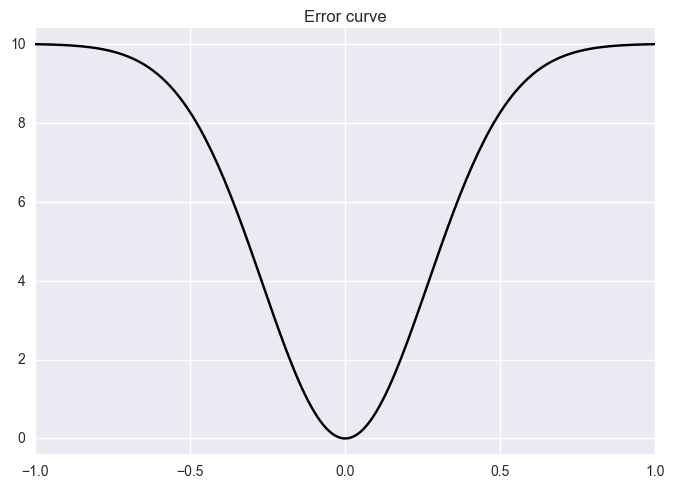

In [8]:
(xs, ys, ds) = make_bowl_data()
plt.plot(xs, ys, color='black')
plt.ylim(-0.4, 10.4)
#plt.yticks([0, 2, 4, 6, 8, 10], [0, .2, .4, .6, .8, 1.0])
plt.title("Error curve")
file_helper.save_figure('just-error-curve')
plt.show()

In [9]:
# Not all that useful with matplotlib because of its crazy scaling, so unless the
# plot is square and uses equal axes in X and Y the arrows won't look right. Sigh.
def draw_arrow(x0, x1, y0, y1, head_len):
    def set_length(vec, length):
        scl = math.sqrt((vec[0]**2) + (vec[1]**2))
        f = length/scl
        v = [vec[0]*f, vec[1]*f]
        return v
    if (x0 == x1) or (y0 == y1):
        return
    tangent = set_length([x1-x0, y1-y0], -1.0)
    norm = set_length([-tangent[1], tangent[0]], 0.7)
    v = set_length([tangent[0]+norm[0], tangent[1]+norm[1]], head_len)
    plt.plot([x1, x1+v[0]], [y1, y1+v[1]], lw=1, color='green')
    v = set_length([tangent[0]-norm[0], tangent[1]-norm[1]], head_len)
    plt.plot([x1, x1+v[0]], [y1, y1+v[1]], lw=1, color='green')
    plt.plot([x0, x1], [y0, y1], lw=1, color='green')

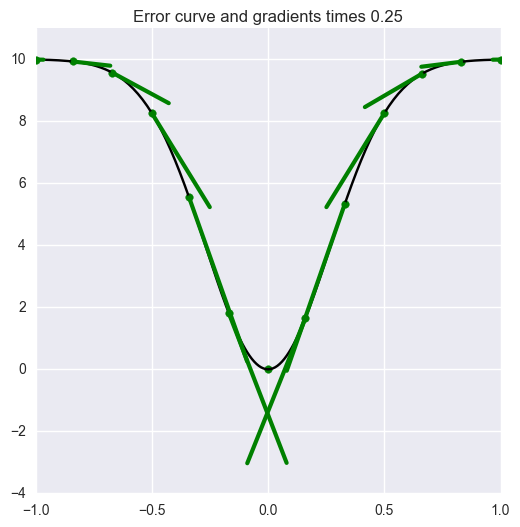

In [10]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(6,6))
plt.plot(xs, ys, color='black')
plt.plot([0,0], [0,0], lw=1, color='black')
gscl = .25
for fi in np.linspace(0, len(ds)-1, 13):
    i = int(fi)
    theta = math.atan2(ds[i], 1)
    dx = ds[i] * math.cos(theta)
    dy = ds[i] * math.sin(theta)
    plt.plot([xs[i], xs[i]-(gscl*dx)], [ys[i], ys[i]-(gscl*dy)], lw=3, color='green')
    plt.scatter([xs[i]],[ys[i]], color='green', s=30)
plt.title('Error curve and gradients times '+str(gscl))
plt.xlim(-1, 1)
plt.ylim(-4, 11)
#plt.yticks([-4, -2, 0, 2, 4, 6, 8, 10], [-.4, -.2, 0, .2, .4, .6, .8, 1.0])
file_helper.save_figure('error-curve-and-gradients-'+str(gscl))
plt.show()

In [11]:
def plot_learning(xs, ys, ds, start_x, num_pts, start_eta, eta_falloff, momentum=False, gamma=0, nesterov=False):
    np.random.seed(42)
    plt.plot(xs, ys, color='#aaaaaa', zorder=10)
    v = start_x
    ymin = -0.2
    ymax = 1.2
    c = hsv_to_rgb([np.random.uniform(0,1), np.random.uniform(0.8,1), np.random.uniform(0.25,0.75)])
    x, y, d = get_xyd_at_val(start_x, xs, ys, ds)
    plt.scatter([x], [y], s=130, c=c, zorder=30)
    eta = start_eta
    last_vx = 0
    last_vy = 0
    errors = [y]
    
    for i in range(num_pts-1):
        color_scale = 1-((i+1)/(num_pts-1))
        c = np.random.uniform(.2, .8, size=3)
        c = hsv_to_rgb([np.random.uniform(0,1), .8, np.random.uniform(0.5,0.75)])

        x, y, d = get_xyd_at_val(v, xs, ys, ds)
        errors.append(y)
        sign_d = np.sign(d)
        if nesterov:
            (predict_x, predict_y, predict_d) = get_xyd_at_val(x - last_vx, xs, ys, ds)
            d = predict_d
            sign_d = np.sign(d)
        
        theta = math.atan2(d, 1)
        vx = d * math.cos(theta)
        vy = d * math.sin(theta)
        vx *= eta
        vy *= eta

        if momentum or nesterov:
            gvx = gamma * last_vx
            gvy = gamma * last_vy 
            plt.plot([x, x-vx, x-vx-gvx], [y, y-vy, y-vy-gvy], color=c, zorder=20)
            vx = vx+gvx
            vy = vy+gvy
        else:
            plt.plot([x, x-vx], [y, y-vy], color=c, zorder=20)
        
        last_vx = vx
        last_vy = vy
        newx = x-vx
        xx, newy, dd = get_xyd_at_val(newx, xs, ys, ds)
        plt.plot([newx, newx], [y-vy, newy], color='#aaaaaa', zorder=10)
        plt.scatter([x-vx], [newy], s=130, c=c, zorder=30)
        ymin = min(ymin, newy)
        ymax = max(ymax, newy)
        v = newx
        eta *= eta_falloff
        
    plt.xlim(-1,1)
    plt.xticks([],[])
    plt.yticks([],[])
    return errors

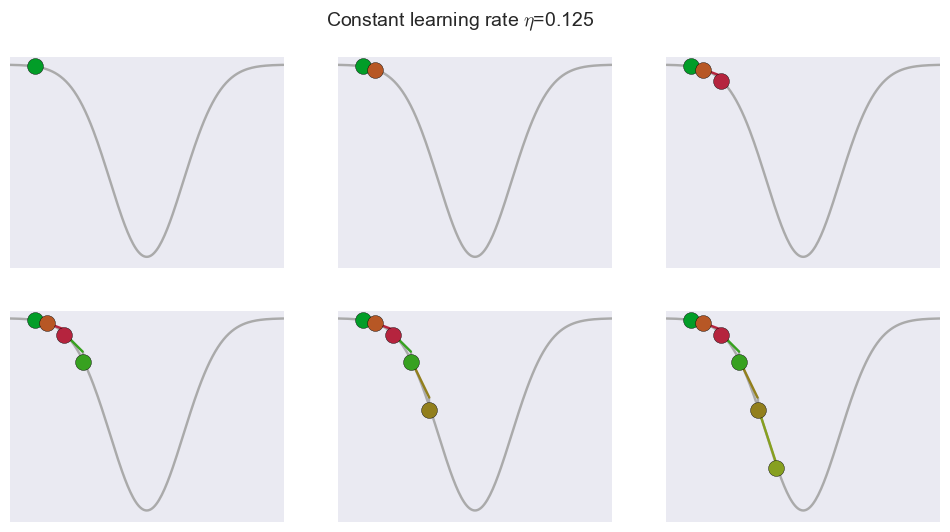

In [12]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
start_eta=0.125
for y in range(2):
    for x in range(3):
        plt.subplot(2, 3, 1+x+(y*3))
        plot_learning(xs, ys, ds, -0.83, num_pts=1+x+(y*3), start_eta=start_eta, eta_falloff=1)
        plt.ylim(-0.6, 10.4)
plt.suptitle("Constant learning rate $\eta$="+str(start_eta), fontsize=14)
file_helper.save_figure("constant-learning-rate-grid")
plt.show()

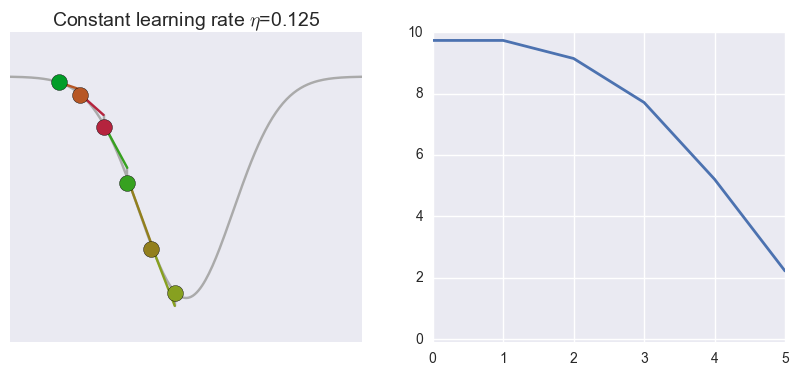

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
start_eta=0.125
errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=start_eta, eta_falloff=1)
plt.title("Constant learning rate $\eta$="+str(start_eta), fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("constant-learning-rate")
plt.show()

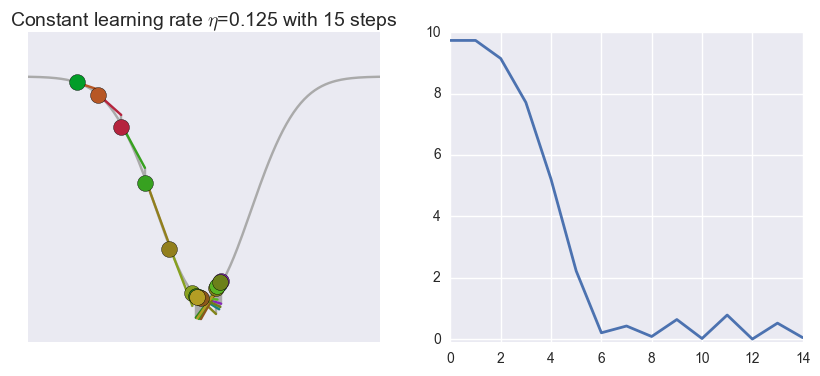

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
start_eta=0.125
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=start_eta, eta_falloff=1)
plt.title("Constant learning rate $\eta$="+str(start_eta)+" with 15 steps", fontsize=14)
plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("constant-learning-rate-15-steps")
plt.show()

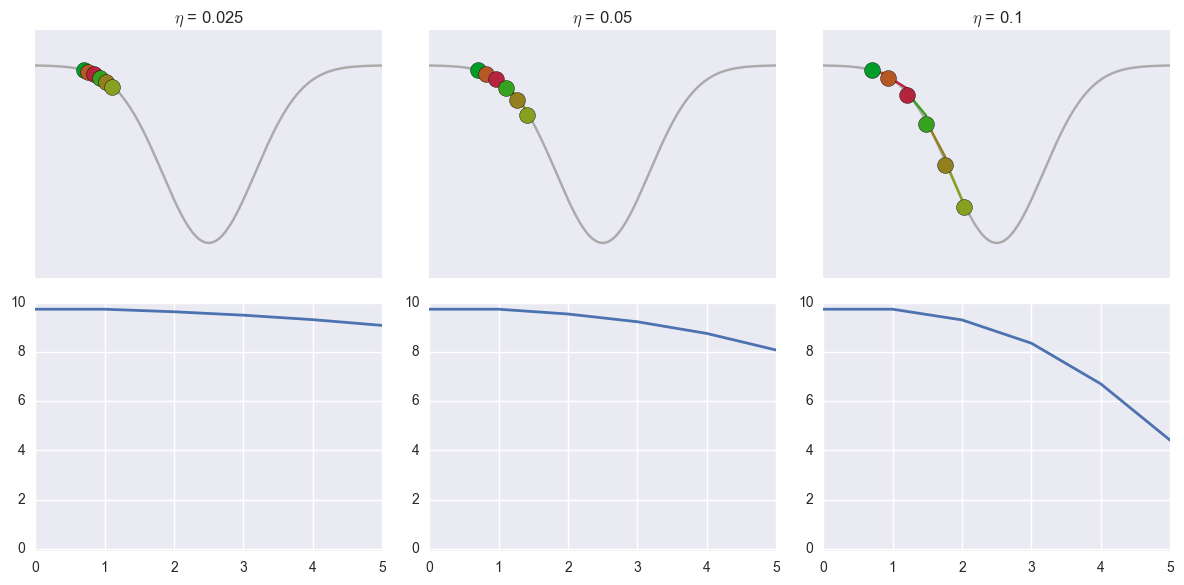

In [15]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
etas = [ .025, .05, .1]
for p in range(3):
    plt.subplot(2, 3, 1+p)
    errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=etas[p], eta_falloff=1)
    plt.title("$\eta$ = "+str(etas[p]))
    plt.subplot(2, 3, 4+p)
    plt.plot(range(len(errors)), errors, lw=2)
    plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure('different-constant-small-etas-6')
plt.show()

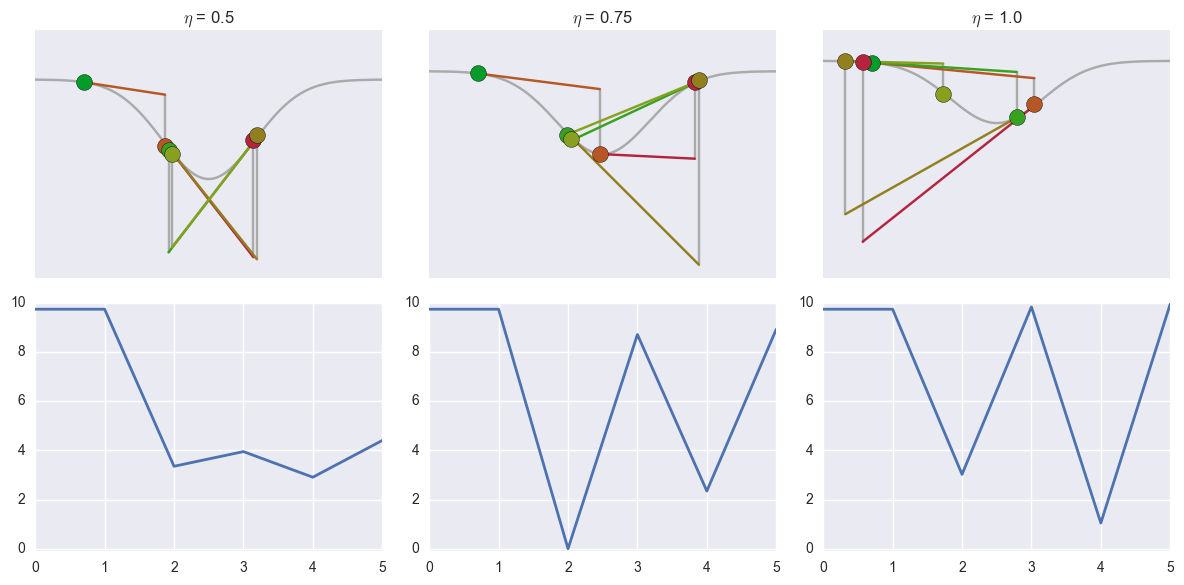

In [16]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
etas = [ .5, .75, 1.0]
for p in range(3):
    plt.subplot(2, 3, 1+p)
    errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=etas[p], eta_falloff=1)
    plt.title("$\eta$ = "+str(etas[p]))
    plt.subplot(2, 3, 4+p)
    plt.plot(range(len(errors)), errors, lw=2)
    plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure('different-constant-large-etas-6')
plt.show()

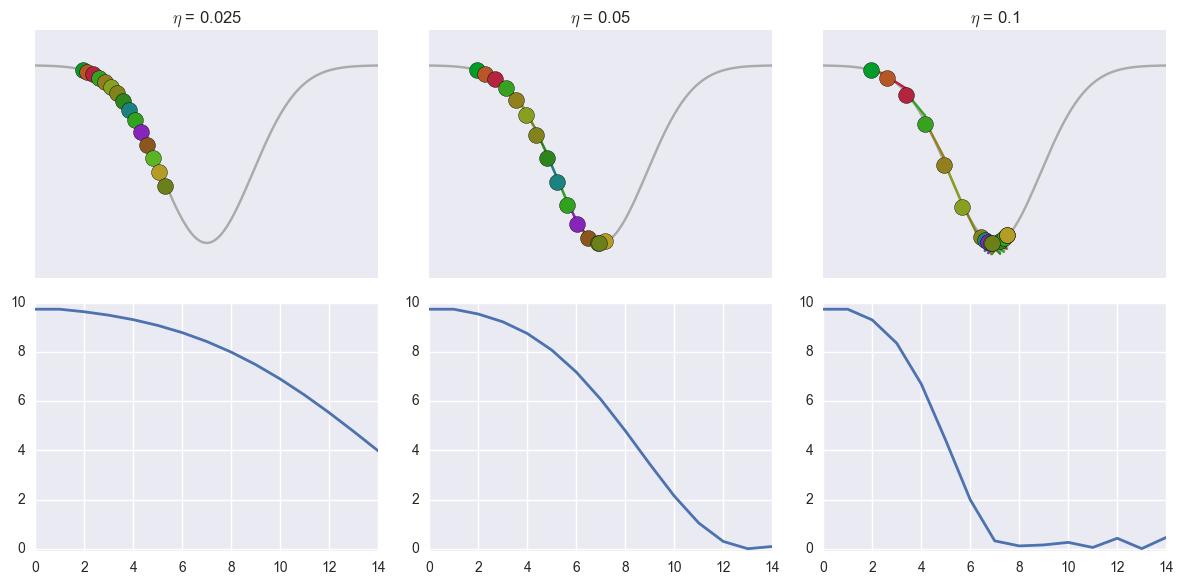

In [17]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
etas = [ .025, .05, .1]
for p in range(3):
    plt.subplot(2, 3, 1+p)
    errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=etas[p], eta_falloff=1)
    plt.title("$\eta$ = "+str(etas[p]))
    plt.subplot(2, 3, 4+p)
    plt.plot(range(len(errors)), errors, lw=2)
    plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure('different-constant-small-etas-15')
plt.show()

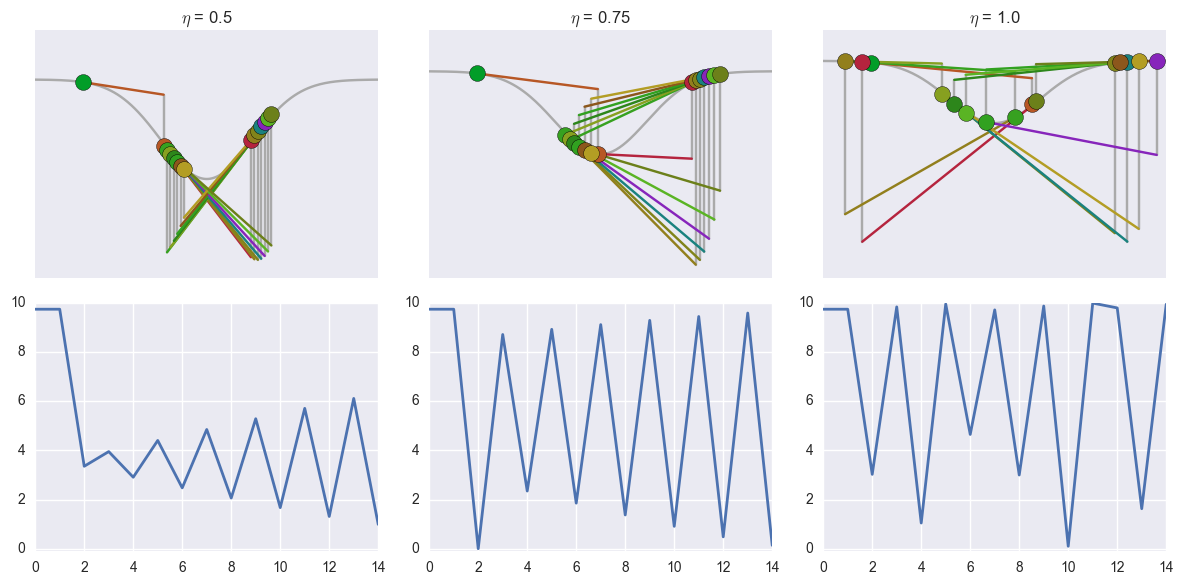

In [18]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
etas = [ .5, .75, 1.0 ]
for p in range(3):
    plt.subplot(2, 3, 1+p)
    errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=etas[p], eta_falloff=1)
    plt.title("$\eta$ = "+str(etas[p]))
    plt.subplot(2, 3, 4+p)
    plt.plot(range(len(errors)), errors, lw=2)
    plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure('different-constant-large-etas-15')
plt.show()

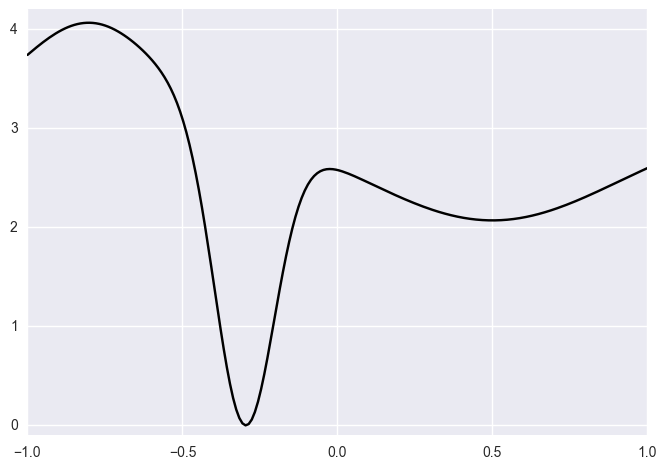

In [19]:
(xs, ys, ds) = make_overshoot_valley()
plt.plot(xs, ys, color='black')
plt.ylim(-0.1, 4.2)
file_helper.save_figure("overshoot-demo-curve")
plt.show()

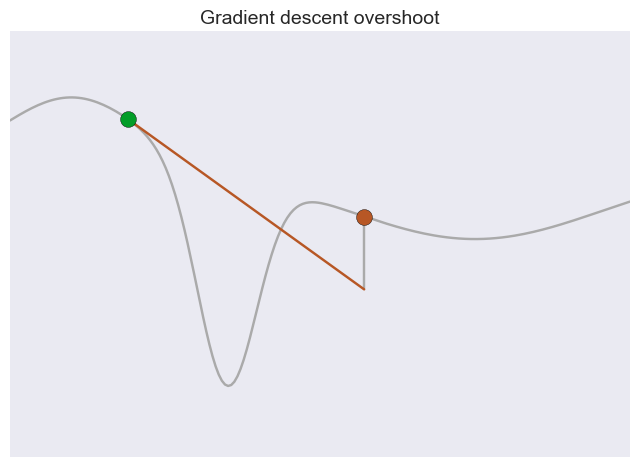

In [20]:
(xs, ys, ds) = make_overshoot_valley()
plot_learning(xs, ys, ds, -0.63, num_pts=2, start_eta=0.8, eta_falloff=1)
plt.title("Gradient descent overshoot", fontsize=14)
file_helper.save_figure("gradient-descent-overshoot")
plt.show()

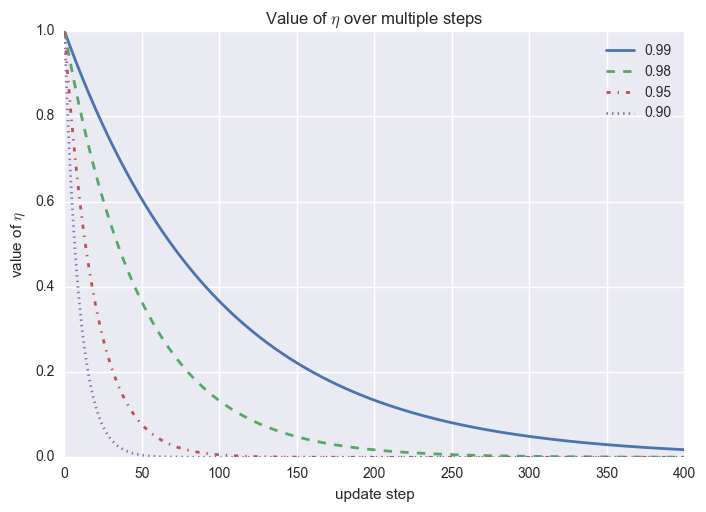

In [21]:
x = np.linspace(0, 400, 401)
y99 = .99 ** x
y98 = .98 ** x
y95 = .95 ** x
y90 = .90 ** x
plt.plot(x, y99, label='0.99', lw=2, linestyle='-')
plt.plot(x, y98, label='0.98', lw=2, linestyle='--')
plt.plot(x, y95, label='0.95', lw=2, linestyle='-.')
plt.plot(x, y90, label='0.90', lw=2, linestyle=':')
plt.legend(loc='upper right')
plt.xlabel('update step')
plt.ylabel('value of $\eta$')
plt.title('Value of $\eta$ over multiple steps')
file_helper.save_figure('exponential-decay')
plt.show()

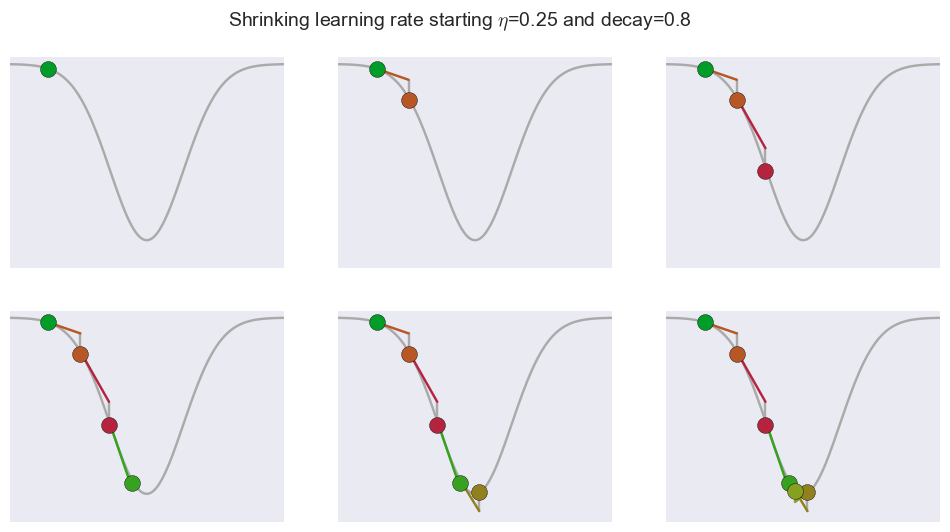

In [22]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
start_eta=0.25
eta_falloff=0.8
for y in range(2):
    for x in range(3):
        plt.subplot(2, 3, 1+x+(y*3))
        plot_learning(xs, ys, ds, -0.73, num_pts=1+x+(y*3), start_eta=start_eta, eta_falloff=eta_falloff)
        plt.ylim(-1.6, 10.4)
plt.suptitle("Shrinking learning rate starting $\eta$="+str(start_eta)+" and decay="+str(eta_falloff), fontsize=14)
file_helper.save_figure("shrinking-learning-rate-grid")
plt.show()

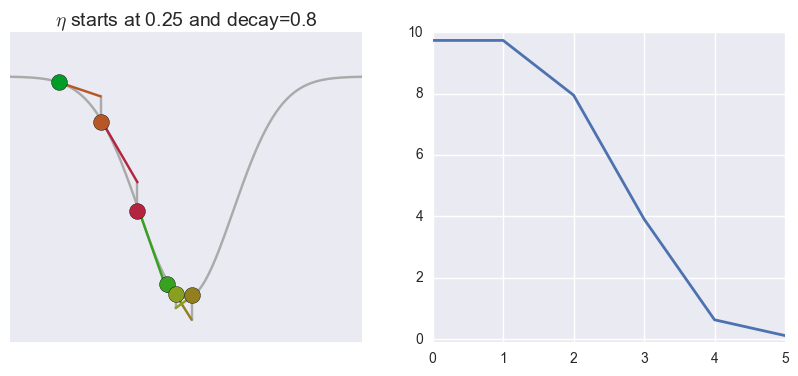

In [23]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
start_eta=0.25
eta_falloff=0.8
errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=start_eta, eta_falloff=eta_falloff)
plt.title("$\eta$ starts at "+str(start_eta)+" and decay="+str(eta_falloff), fontsize=14)
#save_figure("shrinking-learning-rate")

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-6-steps")
plt.show()

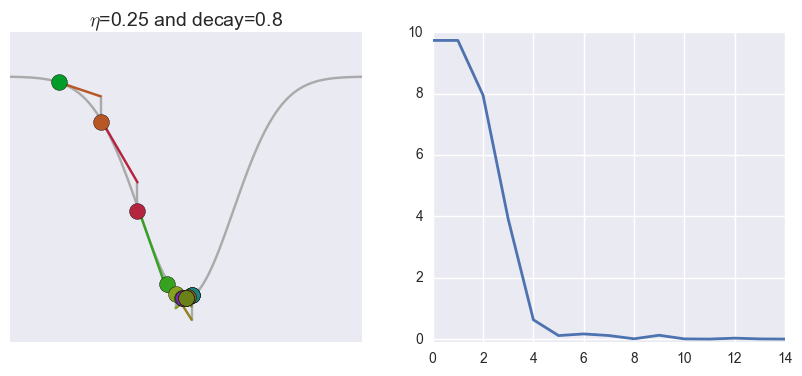

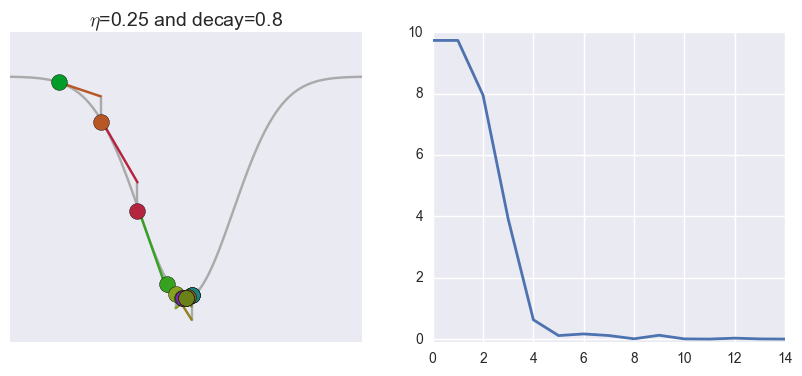

In [25]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
start_eta=0.25
eta_falloff=0.8
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=start_eta, eta_falloff=eta_falloff)
plt.title("$\eta$="+str(start_eta)+" and decay="+str(eta_falloff), fontsize=14)
#save_figure("shrinking-learning-rate-15-steps")

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-15-steps")
plt.show()

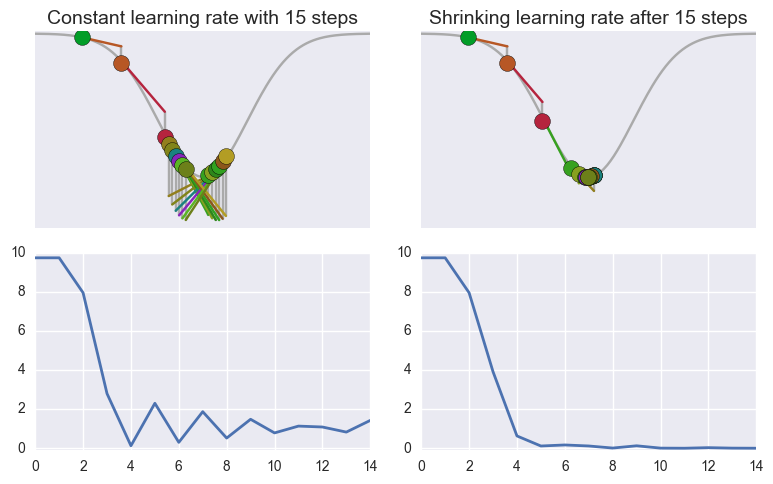

In [26]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(8,5))
plt.subplot(2, 2, 1)
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=0.25, eta_falloff=1)
plt.title("Constant learning rate with 15 steps", fontsize=14)
plt.ylim(-3.6, 10.2)
plt.subplot(2, 2, 3)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
plt.subplot(2, 2, 2)
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=0.25, eta_falloff=0.8)
plt.title("Shrinking learning rate after 15 steps", fontsize=14)
plt.ylim(-3.6, 10.2)
plt.subplot(2, 2, 4)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
plt.tight_layout()
file_helper.save_figure("constant-and-shrinking-learning-rate-15-steps")
plt.show()

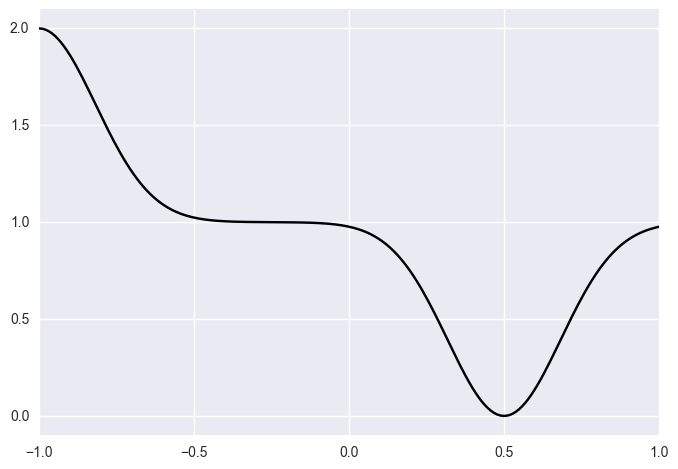

In [27]:
(xs, ys, ds) = make_up_plateau_down()
plt.plot(xs, ys, color='black')
plt.ylim(-0.1, 2.1)
file_helper.save_figure("momentum-demo-curve")
plt.show()

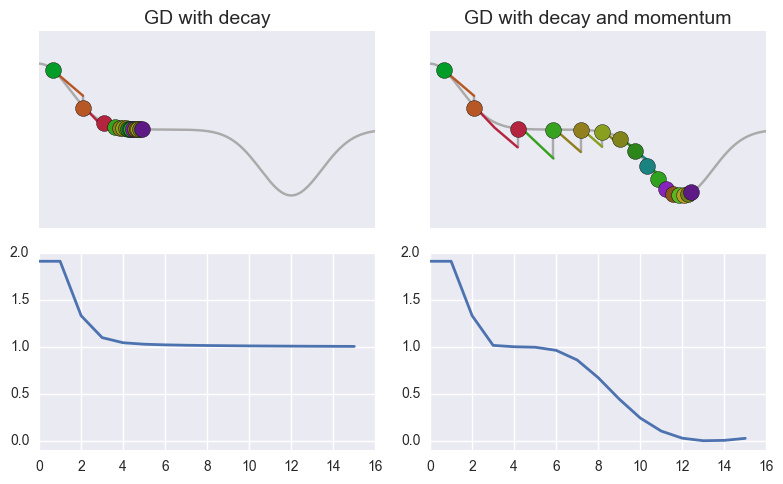

In [28]:
(xs, ys, ds) = make_up_plateau_down()
plt.figure(figsize=(8,5))
plt.subplot(2, 2, 1)
errors = plot_learning(xs, ys, ds, -0.93, num_pts=16, start_eta=0.2, eta_falloff=.6)
plt.title("GD with decay", fontsize=14)
plt.subplot(2, 2, 3)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 2)
plt.subplot(2, 2, 2)
errors = plot_learning(xs, ys, ds, -0.93, num_pts=16, start_eta=0.2, eta_falloff=.6, momentum=True, gamma=0.75)
plt.title("GD with decay and momentum", fontsize=14)
plt.subplot(2, 2, 4)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 2)
plt.tight_layout()
file_helper.save_figure("gd-plateau-with-momentum")
plt.show()

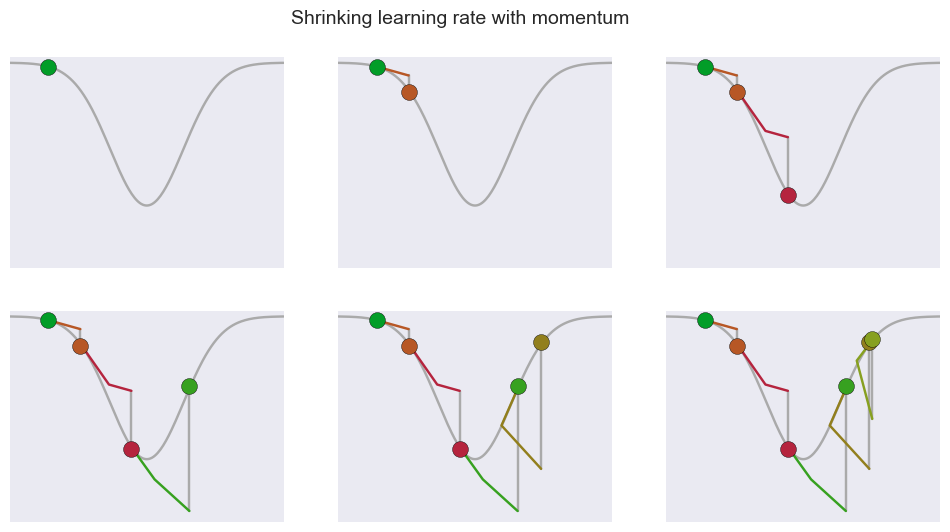

In [29]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
for y in range(2):
    for x in range(3):
        plt.subplot(2, 3, 1+x+(y*3))
        plot_learning(xs, ys, ds, -0.73, num_pts=1+x+(y*3), start_eta=0.25, eta_falloff=.8, 
                      momentum=True, gamma=0.7)
        plt.ylim(-4.4, 10.4)
plt.suptitle("Shrinking learning rate with momentum", fontsize=14)
file_helper.save_figure("shrinking-learning-rate-with-momentum-grid")
plt.show()

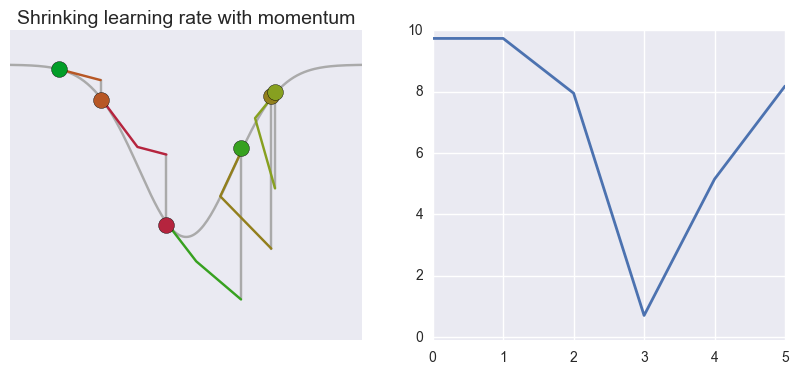

In [30]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=0.25, eta_falloff=0.8, 
                      momentum=True, gamma=0.7)
plt.title("Shrinking learning rate with momentum", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-with-momentum")
plt.show()

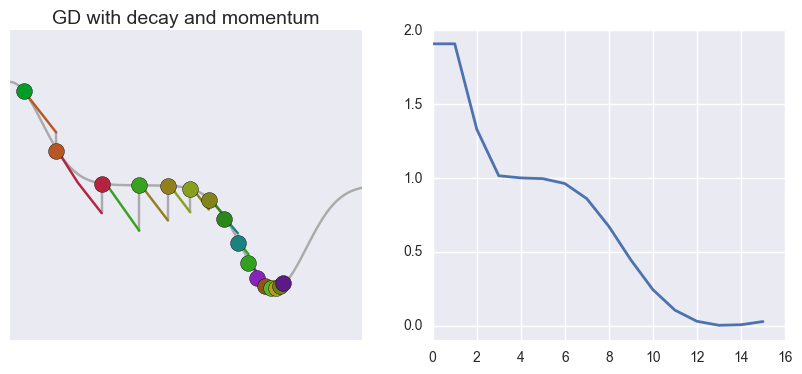

In [31]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_up_plateau_down()
errors = plot_learning(xs, ys, ds, -0.93, num_pts=16, start_eta=0.2, eta_falloff=.6, momentum=True, gamma=0.75)
plt.title("GD with decay and momentum", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 2)
file_helper.save_figure("gd-plateau-with-momentum-only")
plt.show()

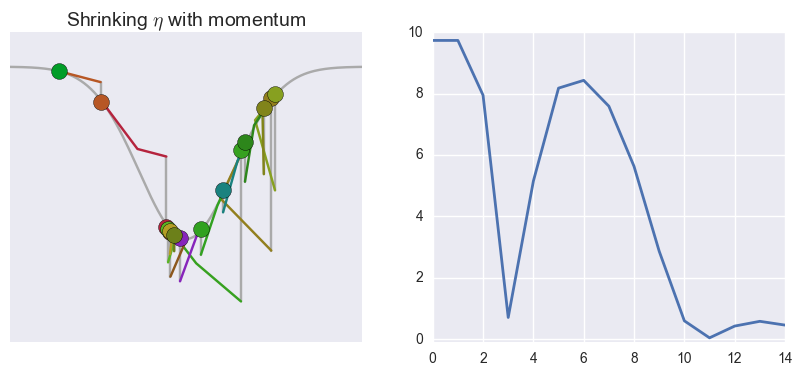

In [32]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=0.25, eta_falloff=0.8, 
                      momentum=True, gamma=0.7)
plt.title("Shrinking $\eta$ with momentum", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-with-momentum-15-pts")
plt.show()

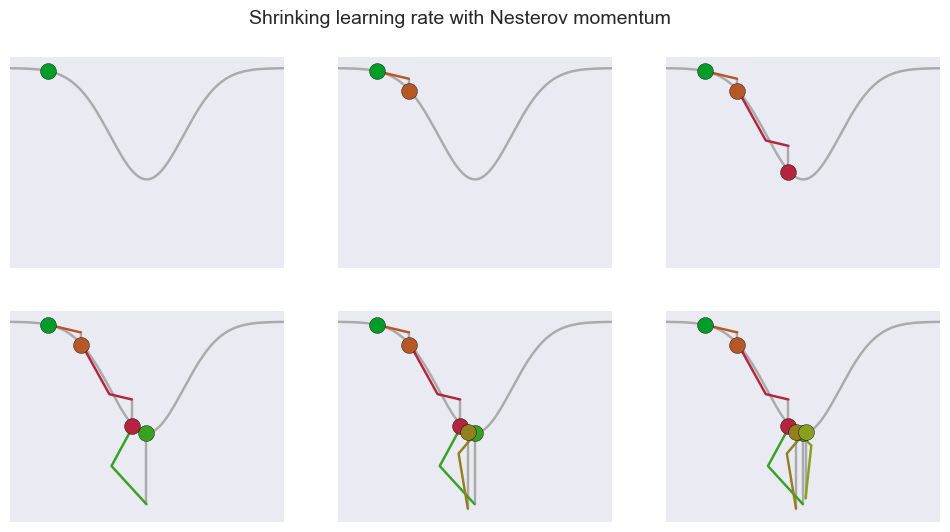

In [33]:
(xs, ys, ds) = make_bowl_data()
plt.figure(figsize=(12,6))
for y in range(2):
    for x in range(3):
        plt.subplot(2, 3, 1+x+(y*3))
        plot_learning(xs, ys, ds, -0.73, num_pts=1+x+(y*3), start_eta=0.25, eta_falloff=.8, 
                      momentum=True, gamma=0.7, nesterov=True)
        plt.ylim(-8, 11)
plt.suptitle("Shrinking learning rate with Nesterov momentum", fontsize=14)
file_helper.save_figure("shrinking-learning-rate-with-nesterov-momentum-grid")
plt.show()

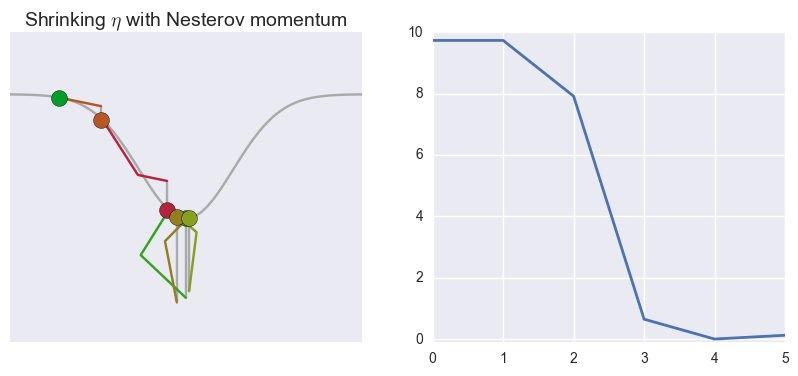

In [34]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
errors = plot_learning(xs, ys, ds, -0.73, num_pts=6, start_eta=0.25, eta_falloff=0.8, 
                      momentum=True, gamma=0.7, nesterov=True)
plt.title("Shrinking $\eta$ with Nesterov momentum", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-with-nesterov-momentum")
plt.show()

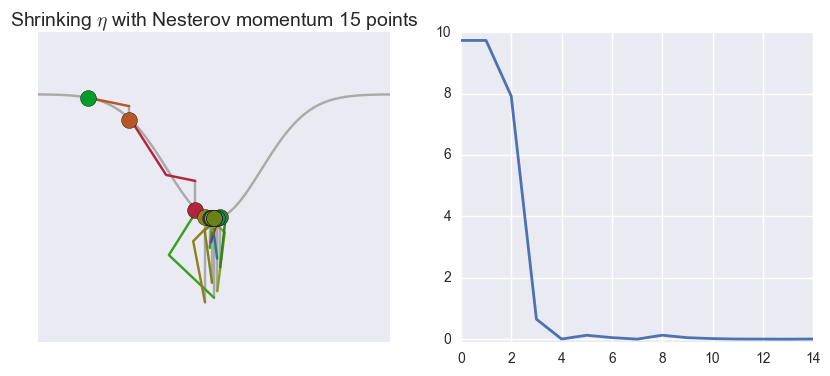

In [35]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
(xs, ys, ds) = make_bowl_data()
errors = plot_learning(xs, ys, ds, -0.73, num_pts=15, start_eta=0.25, eta_falloff=0.8, 
                      momentum=True, gamma=0.7, nesterov=True)
plt.title("Shrinking $\eta$ with Nesterov momentum 15 points", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(range(len(errors)), errors, lw=2)
plt.ylim(-0.1, 10)
file_helper.save_figure("shrinking-learning-rate-with-nesterov-momentum-15-pts")
plt.show()